In [2]:
import os
import numpy as np
import pandas as pd
from tqdm import tqdm
from matplotlib import pyplot as plt

from sklearn import preprocessing
from sklearn.svm import SVC, LinearSVC
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow import keras
import keras_tuner as kt
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.optimizers import Adam, SGD, Adagrad
from tensorflow.keras.metrics import Accuracy, BinaryAccuracy, CategoricalAccuracy, mean_squared_error
from tensorflow.keras.layers import Conv2D, Conv1D, Dense, Flatten, Reshape, LeakyReLU, Dropout, UpSampling2D, UpSampling1D, Softmax, MaxPool1D

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
os.environ['TF_ENABLE_ONEDNN_OPTS'] = '1'
tqdm.pandas()

print(pd.__version__)
print(tf.__version__)
print("GPUs Available: ", tf.config.list_physical_devices('GPU'))

2.0.2
2.12.0
GPUs Available:  []


In [3]:
data_path = save_path = os.path.join('..', '..', 'data', 'mfcc_data')
data_path

'../../data/mfcc_data'

In [4]:
df = pd.read_csv(os.path.join(data_path, 'aa.csv'), sep=',', index_col=False)
df.rename(columns = {'Unnamed: 0':'per_frame_idx'}, inplace = True)
df.head()

,per_frame_idx,mb_name,f1,f2,f3,f4,f5,f6,f7,f8,f9,f10,f11,f12,phonon,asthma_status
0,0,Gaurav,61.123414,9.845393,10.817043,7.056085,7.272934,5.614048,4.491151,4.172515,2.286071,2.837438,2.339272,2.766470,aa_0,Control
1,1,Gaurav,26.805195,23.643036,19.462853,15.425544,12.429753,10.795815,10.223204,10.023100,9.501163,8.302703,6.560850,4.790960,aa_0,Control
2,2,Gaurav,30.082260,25.409986,19.316051,13.504215,9.194826,6.793358,6.015062,6.272963,7.025842,7.901014,8.629334,8.968523,aa_0,Control
3,3,Gaurav,27.535518,24.261880,20.139553,16.368507,13.601135,11.807386,10.589570,9.629306,8.898376,8.510073,8.410082,8.236045,aa_0,Control
4,4,Gaurav,19.493349,17.590766,15.298169,13.292620,11.786129,10.563364,9.328993,8.018267,6.815018,5.924896,5.365196,4.971466,aa_0,Control


In [5]:
df_req = df.drop(['per_frame_idx', 'mb_name', 'phonon'], axis=1)
df_req.head()

,f1,f2,f3,f4,f5,f6,f7,f8,f9,f10,f11,f12,asthma_status
0,61.123414,9.845393,10.817043,7.056085,7.272934,5.614048,4.491151,4.172515,2.286071,2.837438,2.339272,2.766470,Control
1,26.805195,23.643036,19.462853,15.425544,12.429753,10.795815,10.223204,10.023100,9.501163,8.302703,6.560850,4.790960,Control
2,30.082260,25.409986,19.316051,13.504215,9.194826,6.793358,6.015062,6.272963,7.025842,7.901014,8.629334,8.968523,Control
3,27.535518,24.261880,20.139553,16.368507,13.601135,11.807386,10.589570,9.629306,8.898376,8.510073,8.410082,8.236045,Control
4,19.493349,17.590766,15.298169,13.292620,11.786129,10.563364,9.328993,8.018267,6.815018,5.924896,5.365196,4.971466,Control


In [6]:
def conv_to_32(df, cols): df[cols] = df[cols].astype(np.float32)

conv_to_32(df_req, ['f1', 'f2', 'f3', 'f4', 'f5', 'f6', 'f7', 'f8', 'f9', 'f10', 'f11', 'f12'])
df_req.head()


,f1,f2,f3,f4,f5,f6,f7,f8,f9,f10,f11,f12,asthma_status
0,61.123413,9.845393,10.817043,7.056085,7.272934,5.614048,4.491150,4.172515,2.286071,2.837438,2.339272,2.766469,Control
1,26.805195,23.643036,19.462852,15.425544,12.429753,10.795815,10.223204,10.023100,9.501163,8.302703,6.560850,4.790960,Control
2,30.082260,25.409985,19.316051,13.504214,9.194826,6.793358,6.015062,6.272963,7.025842,7.901014,8.629334,8.968523,Control
3,27.535519,24.261881,20.139553,16.368507,13.601135,11.807386,10.589570,9.629306,8.898376,8.510074,8.410082,8.236045,Control
4,19.493349,17.590767,15.298168,13.292620,11.786129,10.563364,9.328993,8.018267,6.815018,5.924896,5.365196,4.971466,Control


In [7]:
df_req['asthma_status'] = df_req['asthma_status'].astype('category')
df_req['asthma_status'] = df_req['asthma_status'].cat.codes
df_req.head()

,f1,f2,f3,f4,f5,f6,f7,f8,f9,f10,f11,f12,asthma_status
0,61.123413,9.845393,10.817043,7.056085,7.272934,5.614048,4.491150,4.172515,2.286071,2.837438,2.339272,2.766469,0
1,26.805195,23.643036,19.462852,15.425544,12.429753,10.795815,10.223204,10.023100,9.501163,8.302703,6.560850,4.790960,0
2,30.082260,25.409985,19.316051,13.504214,9.194826,6.793358,6.015062,6.272963,7.025842,7.901014,8.629334,8.968523,0
3,27.535519,24.261881,20.139553,16.368507,13.601135,11.807386,10.589570,9.629306,8.898376,8.510074,8.410082,8.236045,0
4,19.493349,17.590767,15.298168,13.292620,11.786129,10.563364,9.328993,8.018267,6.815018,5.924896,5.365196,4.971466,0


In [8]:
df_req['asthma_status'].value_counts()

asthma_status
0    455559
1    319867
Name: count, dtype: int64

In [10]:
Y = df_req.loc[:, 'asthma_status'].to_numpy()
X = df_req.loc[:, df_req.columns != 'asthma_status'].to_numpy()

print(X.shape)
print(Y.shape)

(775426, 12)
(775426,)


In [14]:
scaler = preprocessing.StandardScaler(copy=True, with_mean=True, with_std=True)
# scaler = preprocessing.MinMaxScaler()
X_scaled = scaler.fit_transform(X)

In [15]:
type(X_scaled[0][0])

numpy.float32

In [41]:
x_train, x, y_train, y = train_test_split(X_scaled, Y, test_size=0.20, shuffle=True, random_state=137, stratify=Y)
x_val, x_test, y_val, y_test = train_test_split(x, y, test_size=0.33, shuffle=True, random_state=137, stratify=y)

### Autoencoder

In [17]:
input_dim = x_train.shape[1] 
input_dim

12

In [42]:
class AutoEncoder:
    def __init__(self, input_dim):
        self.input_dim = input_dim

        self.encoder = self.make_encoder()
        self.decoder = self.make_decoder()
        self.autoencoder = keras.Sequential([self.encoder, self.decoder], name='Phonon_Autoencoder')

        self.autoencoder.compile(optimizer='adam', loss='mse')

    def make_encoder(self):
        encoder = keras.Sequential([
            Dense(32, activation='relu', input_shape=(self.input_dim,)),
            Dense(64, activation='relu'),
            Dense(128, activation='relu')
        ], name='phonon_encoder')
        return encoder

    
    def make_decoder(self):
        decoder = keras.Sequential([
            Dense(64, activation='relu', input_shape=(128,)),
            Dense(32, activation='relu'),
            Dense(input_dim, activation='linear')
        ], name='phonon_decoder')
        return decoder

ae = AutoEncoder(12)

In [ ]:
ae.encoder.summary()

In [ ]:
ae.decoder.summary()

In [43]:
ae.autoencoder.summary()

Model: "Phonon_Autoencoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 phonon_encoder (Sequential)  (None, 128)              10848     
                                                                 
 phonon_decoder (Sequential)  (None, 12)               10732     
                                                                 
Total params: 21,580
Trainable params: 21,580
Non-trainable params: 0
_________________________________________________________________


In [36]:
ae.autoencoder.fit(x_train, x_train, validation_data=(x_val, x_val), epochs=10, batch_size=32)

Epoch 1/10
16963/16963 [==============================] - 53s 3ms/step - loss: 6.7332e-05 - val_loss: 1.5893e-05
Epoch 2/10
16963/16963 [==============================] - 61s 4ms/step - loss: 6.4431e-05 - val_loss: 7.7915e-05
Epoch 3/10
16963/16963 [==============================] - 62s 4ms/step - loss: 6.4708e-05 - val_loss: 3.4974e-05
Epoch 4/10
16963/16963 [==============================] - 58s 3ms/step - loss: 6.2937e-05 - val_loss: 3.1524e-05
Epoch 5/10
16963/16963 [==============================] - 68s 4ms/step - loss: 6.2657e-05 - val_loss: 2.0856e-05
Epoch 6/10
16963/16963 [==============================] - 74s 4ms/step - loss: 6.0703e-05 - val_loss: 1.9710e-05
Epoch 7/10
16963/16963 [==============================] - 65s 4ms/step - loss: 6.0145e-05 - val_loss: 1.2742e-04
Epoch 8/10
16963/16963 [==============================] - 76s 4ms/step - loss: 6.1311e-05 - val_loss: 1.7970e-05
Epoch 9/10
16963/16963 [==============================] - 69s 4ms/step - loss: 5.8948e-05 - val_

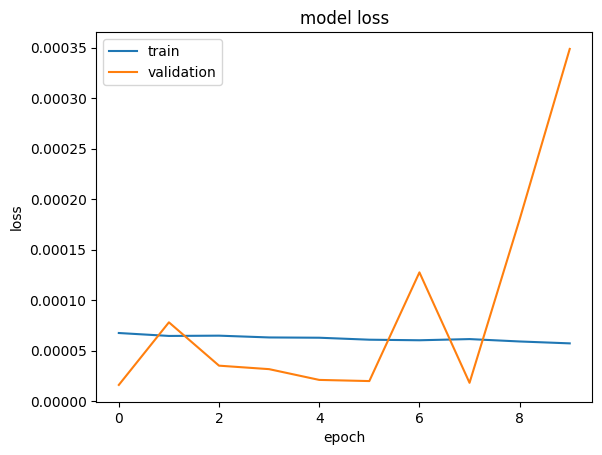

In [38]:
metric_hist = ae.autoencoder.history.history

# summarize history for accuracy
# plt.plot(metric_hist['binary_accuracy'])
# plt.plot(metric_hist['val_binary_accuracy'])
# plt.title('model binary_accuracy')
# plt.ylabel('binary_accuracy')
# plt.xlabel('epoch')
# plt.legend(['train', 'validation'], loc='upper left')
# plt.show()
# summarize history for loss
plt.plot(metric_hist['loss'])
plt.plot(metric_hist['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

### Neural Network

In [135]:
def make_model4_u():

    ### model layout
    model = keras.Sequential()
    model.add(Dense(12, activation='linear', input_shape=(12,)))
    model.add(Dense(12, activation='linear'))
    model.summary()

    ### model compiling
    model.compile(
        loss='mean_squared_error',
        optimizer='adam',
        metrics=[Accuracy()]
    )

    return model

model_aa = make_model4_u()

In [ ]:
model_aa.fit(x_train, x_train, validation_data=(x_train, x_train), batch_size=128, epochs=20, use_multiprocessing=True)

In [83]:
def reconstructionScore(originalDF, reducedDF):
    loss = np.sum((np.array(originalDF) - np.array(reducedDF))**2, axis=0)
    # loss = pd.Series(data=loss,index=originalDF.index)
    loss = (loss-np.min(loss))/(np.max(loss)-np.min(loss))
    print('Mean for reconstruction scores: ', np.mean(loss))
    return loss

In [84]:
x_pred = model_aa.predict(x_test)
scores = reconstructionScore(x_test, x_pred)
scores

2399/2399 [==============================] - 2s 902us/step


In [111]:
def make_model4t_u(hp):                  
    hp_layer1 = hp.Int('layer1', min_value=12, max_value=100, step=24)
    hp_layer2 = hp.Int('layer2', min_value=12, max_value=100, step=24)
    hp_layer3 = hp.Int('layer3', min_value=12, max_value=100, step=24)
    hp_layer4 = hp.Int('layer4', min_value=12, max_value=100, step=24)
    hp_activation = hp.Choice('activation', ['linear', 'relu', 'sigmoid'])

    ### model layout
    model = keras.Sequential(name='Phonon_to_Asthama_NN_u')
    model.add(keras.Input(shape=(12,)))
    model.add(Dense(units=hp_layer1, activation=hp_activation))
    model.add(Dense(units=hp_layer2, activation=hp_activation))
    model.add(Dense(units=hp_layer3, activation=hp_activation))
    model.add(Dense(units=hp_layer4, activation=hp_activation))
    model.add(Dropout(0.1))
    model.add(Dense(12, activation=hp_activation))
    model.summary()

    ### model compiling
    model.compile(
        loss='mean_squared_error',
        optimizer='adam',
        metrics=['accuracy']
    )

    return model

In [ ]:
tuner_4t = kt.Hyperband(
    make_model4t_u,
    objective='val_accuracy',
    max_epochs=20,
    factor=3,
    directory='tuned_models',
    project_name='model_4t2_u'
)

In [ ]:
stop_early = keras.callbacks.EarlyStopping(monitor='val_binary_accuracy', patience=3)
tb_storage = keras.callbacks.TensorBoard("/tmp/tb_logs")
tuner_4t.search(x_train, y_train, epochs=20, validation_data=(x_train, y_train), batch_size=128, use_multiprocessing=True, callbacks=[stop_early, tb_storage])

KeyError: 'val_loss'

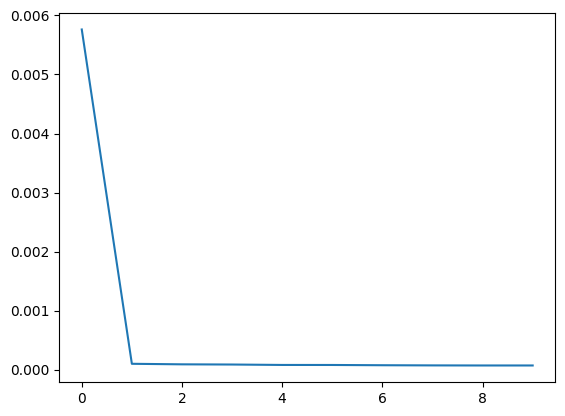

In [34]:
metric_hist = model_aa.history.history

# summarize history for accuracy
# plt.plot(metric_hist['binary_accuracy'])
# plt.plot(metric_hist['val_binary_accuracy'])
# plt.title('model binary_accuracy')
# plt.ylabel('binary_accuracy')
# plt.xlabel('epoch')
# plt.legend(['train', 'validation'], loc='upper left')
# plt.show()
# summarize history for loss
plt.plot(metric_hist['loss'])
plt.plot(metric_hist['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()